In [27]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import sys
import math
import logging
sys.path.append('../')

import dask_geopandas
# some data need to be converted to multi-type again
from utils.save_gdf_to_gdb import save_gdf_to_gdb
#from process.footprint_report import update_ln, update_poly, update_pt
from shapely import Polygon, MultiPolygon
from shapely import affinity
import dask_geopandas

from its_logging.logger_config import logger
logger = logging.getLogger('process.footprint')

In [2]:

veg_gdf = gpd.read_file(r'D:\WORK\wildfire\Interagency-Tracking-System\its\Interagency Tracking System.gdb', 
                                    driver='OpenFileGDB', 
                                    layer='Own_Veg_Region_WUI')


C:\Users\sky\.conda\envs\its_recode\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver OpenFileGDB does not support open option DRIVER
  return ogr_read(
C:\Users\sky\.conda\envs\its_recode\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts.  The processing may be really slow.  You can skip the processing by setting METHOD=SKIP.
  return ogr_read(


In [3]:
append_path = r"D:\WORK\wildfire\Interagency-Tracking-System\its\ITSGDB_backup\V2.0\appended.gdb"

In [4]:
report_path = r"D:\WORK\wildfire\Interagency-Tracking-System\its\ITSGDB_backup\V2.0\reports.gdb"

In [5]:
enriched_polygons = gpd.read_file(append_path, driver='OpenFileGDB', layer='appended_poly')
enriched_points = gpd.read_file(append_path, driver='OpenFileGDB', layer='appended_point')
enriched_lines = gpd.read_file(append_path, driver='OpenFileGDB', layer='appended_line')

C:\Users\sky\.conda\envs\its_recode\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver OpenFileGDB does not support open option DRIVER
  return ogr_read(
C:\Users\sky\.conda\envs\its_recode\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver OpenFileGDB does not support open option DRIVER
  return ogr_read(
C:\Users\sky\.conda\envs\its_recode\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver OpenFileGDB does not support open option DRIVER
  return ogr_read(


In [6]:
years = ['2021', '2022', '2023', '2024']

In [7]:
def get_max_treatment(gdf):
    '''
    only use on specific agencies where treatment is reported with the same geometry
    '''
    max_idx = gdf.groupby(['TRMTID_USER', 'Year_txt'])['ACTIVITY_QUANTITY'].idxmax()
    return gdf.loc[max_idx]

In [8]:
def buffer_overreport_poly(row):
    if row.ACRE_RATIO <= 1:
        return row.geometry
    
    # scale up by centroid if type is polygon
    if isinstance(row.geometry, Polygon):
        return affinity.scale(row.geometry, xfact=np.sqrt(row.ACRE_RATIO), yfact=np.sqrt(row.ACRE_RATIO))
    # scale up by centroid of each polygon in multi-polygon
    else:
        out = []
        for geom in list(row.geometry.geoms):
            out.append(affinity.scale(geom, xfact=np.sqrt(row.ACRE_RATIO), yfact=np.sqrt(row.ACRE_RATIO)))
        return MultiPolygon(out)

In [9]:
def update_pt(enriched_points: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """Update points with buffer calculations."""
    logger.info(f"      initial points count: {len(enriched_points)}")
    
    # Add BufferMeters field
    enriched_points['BufferMeters'] = None
    
    # Calculate buffer for AC units
    mask1 = (enriched_points['ACTIVITY_QUANTITY'].notna()) & (enriched_points['ACTIVITY_UOM'] == 'AC')
    logger.info(f"      points with valid ACTIVITY_QUANTITY and AC units: {mask1.sum()}")
    
    # Buffer point by their reported activity quantity 
    enriched_points.loc[mask1, 'BufferMeters'] = np.sqrt((enriched_points.loc[mask1, 'ACTIVITY_QUANTITY'] * 4046.86) / math.pi)
    
    # Filter for COUNTS_TO_MAS
    mask2 = (enriched_points['COUNTS_TO_MAS'] == 'YES') & (enriched_points['BufferMeters'].notna())
    logger.info(f"      points with COUNTS_TO_MAS='YES' and valid BufferMeters: {mask2.sum()}")
    
    selected_points = enriched_points[mask2].copy()

    selected_points = selected_points[selected_points['BufferMeters'] > 0]
    logger.info(f"      points with BufferMeters > 0: {len(selected_points)}")
    
    # Create buffers
    buffered_geoms = selected_points.apply(
        lambda row: row.geometry.buffer(row['BufferMeters']) if pd.notnull(row['BufferMeters']) else row.geometry,
        axis=1
    )
    
    # Create new GeoDataFrame with buffered geometries
    result = selected_points.copy()
    result.geometry = buffered_geoms
    logger.info(f"      final points count: {len(result)}")
    return result


def update_ln(enriched_lines: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """Update lines with buffer calculations."""
    logger.info(f"      initial lines count: {len(enriched_lines)}")
        
    # Check for case differences
    if 'ACTIVITY_UOM' in enriched_lines.columns:
        unique_uom = enriched_lines['ACTIVITY_UOM'].unique()
        logger.info(f"      unique ACTIVITY_UOM values: {unique_uom}")
    
    # Add BufferMeters field
    enriched_lines['BufferMeters'] = None
    
    # Calculate line lengths
    line_lengths = enriched_lines.geometry.length
    logger.info(f"      lines with length > 0: {(line_lengths > 0).sum()}")
    
    # Modify conditions to be more lenient and check for case variations
    condition1 = enriched_lines['ACTIVITY_QUANTITY'].notna() if 'ACTIVITY_QUANTITY' in enriched_lines.columns else False
    logger.info(f"      lines with valid ACTIVITY_QUANTITY: {condition1.sum() if isinstance(condition1, pd.Series) else 0}")
    
    condition2 = enriched_lines['ACTIVITY_UOM'].str.upper() == 'AC' if 'ACTIVITY_UOM' in enriched_lines.columns else False
    logger.info(f"      lines with ACTIVITY_UOM = 'AC' (case insensitive): {condition2.sum() if isinstance(condition2, pd.Series) else 0}")
    
    # Check combined conditions
    mask1 = condition1 & condition2 & (line_lengths > 0)
    logger.info(f"      lines meeting all conditions: {mask1.sum() if isinstance(mask1, pd.Series) else 0}")
    
    if not isinstance(mask1, pd.Series) or mask1.sum() == 0:
        logger.warning("      no lines meet the filtering criteria. Please check if the required columns exist and contain expected values.")
        return enriched_lines[enriched_lines['geometry'].notna()].head(0)  # Return empty GeoDataFrame with same schema
    
    # Calculate buffer distances
    enriched_lines.loc[mask1, 'BufferMeters'] = (
        (enriched_lines.loc[mask1, 'ACTIVITY_QUANTITY'] * 4046.86) / 
        line_lengths[mask1] / 2
    )
    
    # Check COUNTS_TO_MAS condition
    condition3 =  (enriched_lines['COUNTS_TO_MAS'] == 'YES') & (enriched_lines['BufferMeters'].notna())
    logger.info(f"      lines with COUNTS_TO_MAS = 'YES': {condition3.sum() if isinstance(condition3, pd.Series) else 0}")
    
    condition4 = ~((enriched_lines['BufferMeters'] >= 200) & (enriched_lines['Source'] == 'CalTrans'))
    
    # Final filter
    mask2 = condition3 & condition4
    selected_lines = enriched_lines[mask2].copy()
    
    # caltrans activity is merged with treatment_id/geometry pair
    # safe to only take max to reduce dissolve process time
    caltrans = get_max_treatment(selected_lines[selected_lines.Source == 'CALTRANS'])
    selected_lines = pd.concat([selected_lines[selected_lines.Source != 'CALTRANS'], caltrans],ignore_index=True)
    
    
    # Create buffers
    buffered_geoms = selected_lines.apply(
        lambda row: row.geometry.buffer(row['BufferMeters'], cap_style='flat'),
        axis=1
    )
    
    # Create new GeoDataFrame with buffered geometries
    result = selected_lines.copy()
    result.geometry = buffered_geoms
    logger.info(f"      final lines count: {len(result)}")
    
    return result


def update_poly(enriched_polygons: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """Update polygons with selection criteria."""
    logger.info(f"      initial polygons count: {len(enriched_polygons)}")

    mas_gdf = enriched_polygons[enriched_polygons['COUNTS_TO_MAS'] == 'YES']
    logger.info(f"      polygons with COUNTS_TO_MAS = 'YES': {mas_gdf.shape}")
    
    # inherited from arcpy version
    # from logger there seems to be no such anomoly
    treatment_gdf = enriched_polygons[enriched_polygons['TREATMENT_AREA'] < 100000]
    logger.info(f"      polygons with 'TREATMENT_AREA' < 100000: {treatment_gdf.shape}")
    
    mask = (
        (enriched_polygons['COUNTS_TO_MAS'] == 'YES') & 
        (enriched_polygons['TREATMENT_AREA'] < 100000)
    )

    final_gdf = enriched_polygons[mask].copy()
    
    
        

    # scale up by centroid of polygon geometry if reported acre is larger than geometry area
    final_gdf['ACRE_RATIO'] = final_gdf.ACTIVITY_QUANTITY* 4046.86/(final_gdf.geometry.area)
    final_gdf.geometry = final_gdf.apply(buffer_overreport_poly, axis = 1)
    final_gdf = final_gdf.drop('ACRE_RATIO', axis=1)
    
    
    logger.info(f"      final polygons: {final_gdf.shape}")
    
    return final_gdf

In [10]:
%%time
# Unit of Measure == Acres
# buffer data by activity quantity acre to the exact amount of acres
buffered_pt = update_pt(enriched_points)
buffered_ln = update_ln(enriched_lines)
buffered_poly = update_poly(enriched_polygons)

2025-08-03 19:20:06,594 INFO  [process.footprint     ]        initial points count: 20443
2025-08-03 19:20:06,598 INFO  [process.footprint     ]        points with valid ACTIVITY_QUANTITY and AC units: 19325
2025-08-03 19:20:06,604 INFO  [process.footprint     ]        points with COUNTS_TO_MAS='YES' and valid BufferMeters: 4933
2025-08-03 19:20:06,633 INFO  [process.footprint     ]        points with BufferMeters > 0: 4273
2025-08-03 19:20:06,751 INFO  [process.footprint     ]        final points count: 4273
2025-08-03 19:20:06,754 INFO  [process.footprint     ]        initial lines count: 131658
2025-08-03 19:20:06,767 INFO  [process.footprint     ]        unique ACTIVITY_UOM values: ['AC' 'MI' None 'EA' 'TON']
2025-08-03 19:20:07,285 INFO  [process.footprint     ]        lines with length > 0: 131658
2025-08-03 19:20:07,286 INFO  [process.footprint     ]        lines with valid ACTIVITY_QUANTITY: 131628
2025-08-03 19:20:07,315 INFO  [process.footprint     ]        lines with ACTIVIT

CPU times: total: 17.9 s
Wall time: 18 s


In [14]:
%%time
for y in years:
    poly_cur_y = buffered_poly[buffered_poly['Year_txt'] == y]
    ln_cur_y = buffered_ln[buffered_ln['Year_txt'] == y]
    pt_cur_y = buffered_pt[buffered_pt['Year_txt'] == y]
    
    # timber nonspatial should not follow the spatial operations below
    # take reported value at face value
    # append later to final result
    timber_cur_y = pt_cur_y[pt_cur_y.AGENCY == 'TIMBER']

    
    # concat together
    footprint_cur_y = pd.concat([poly_cur_y, ln_cur_y, pt_cur_y[pt_cur_y.AGENCY != 'TIMBER']], ignore_index=True)
    
    # drop unecessary fields, dissolve by treatment and take max activity quantity 
    # 05/08/2025 UPDATE: subject to change
    dissolved_cur_y = footprint_cur_y[['TRMTID_USER', 'ACTIVITY_QUANTITY', 'geometry']].dissolve('TRMTID_USER', aggfunc='max')
    
    
    # append the first instance of agency value to associated treatment id
    # used later to manually assign onwership for caltrans data specifically
    agency = footprint_cur_y.set_index(footprint_cur_y.TRMTID_USER).loc[dissolved_cur_y.index, 'AGENCY']
    
    dissolved_cur_y['AGENCY'] = agency[~agency.index.duplicated()]
    
    # make valid would split a invalid polygon to multiple valid polygons and convert to MultiPolygon type
    dissolved_cur_y.geometry = dissolved_cur_y.make_valid()
    
    # simplified SIG Meatball&Speghetti function
    # use spatial join to rule out high overlapping
    ##############################################################################################################
    
    # create "meatballs" by taking the representative point of footprint polygons
    dissolved_point = dissolved_cur_y.copy()
    dissolved_point.geometry = dissolved_point.representative_point()
    
    # perform spatial join to find intersecting point/polygon
    # left join to keep all points and multiple polygons
    joined_data = gpd.sjoin(dissolved_point, dissolved_cur_y, how='left', predicate='intersects').reset_index()

    
    # for polygon with multiple overlapping points, find the Treatment ID of those points whose Activity Quantity
    # is smaller than the polygon's Activity Quantity
    footprint_mask = joined_data[joined_data['ACTIVITY_QUANTITY_left'] < joined_data['ACTIVITY_QUANTITY_right']]['TRMTID_USER_left']
    
    # remove these non-qualifying treatments from footprint, essentially the same as taking max for overlapping
    footpring_gdf = dissolved_cur_y.reset_index()
    footpring_gdf = footpring_gdf[~footpring_gdf['TRMTID_USER'].isin(footprint_mask)]
    
    ##############################################################################################################

    # dask spatial join to enrich vegetation, ownership, etc.
    # use representative point for faster sjoin
    footprint_pts = footpring_gdf.copy()
    footprint_pts.geometry = footprint_pts.representative_point()
    ddf = dask_geopandas.from_geopandas(footprint_pts, npartitions=16)
    # TODO: some points may fall outside of veg, ownership layer?
    footprint_enriched = ddf.sjoin(veg_gdf, how='inner', predicate='intersects').compute()
    
    # manually assign CALTRANS ownership to state
    footprint_enriched.loc[footprint_enriched.AGENCY=='CALSTA', 'PRIMARY_OWNERSHIP_GROUP'] = 'STATE'
    
    # reassign the polygon geometry back to enriched footprint
    footprint_enriched.geometry = footpring_gdf.geometry
    # drop artifact columns
    footprint_enriched = footprint_enriched.drop(['index_right', 'Shape_Length', 'Shape_Area'], axis=1)
    
    # assign timber 
    timber_cur_y['WUI'] = 'Non-WUI'
    
    # append timber back to footprint
    footprint_enriched = pd.concat([footprint_enriched, timber_cur_y[footprint_enriched.columns]])
    
    # save to file
    save_gdf_to_gdb(footprint_enriched, report_path, 'footprint' + y)

CPU times: total: 25.8 s
Wall time: 25.8 s


In [11]:
################################################

In [12]:
y = '2023'

In [15]:
# author: James Falter @ARB
# Function to remove duplicate geometries with different coordinate vectors
def remove_duplicates(gdf):
    normalized_wkb = gdf.geometry.apply(lambda geom: geom.normalize().wkb)
    unique_gdf = gdf.loc[~normalized_wkb.duplicated()].reset_index(drop=True)

    return unique_gdf


In [13]:
poly_cur_y = buffered_poly[buffered_poly['Year_txt'] == y]
#ln_cur_y = buffered_ln[buffered_ln['Year_txt'] == y]
pt_cur_y = buffered_pt[buffered_pt['Year_txt'] == y]

# timber nonspatial should not follow the spatial operations below
# take reported value at face value
# append later to final result
timber_cur_y = pt_cur_y[pt_cur_y.AGENCY == 'TIMBER']


# concat together
footprint_cur_y = pd.concat([poly_cur_y, pt_cur_y[pt_cur_y.AGENCY != 'TIMBER']], ignore_index=True)

# drop unecessary fields, dissolve by treatment and take max activity quantity 
# 05/08/2025 UPDATE: subject to change
dissolved_cur_y = footprint_cur_y[['TRMTID_USER', 'ACTIVITY_QUANTITY', 'geometry']].dissolve('TRMTID_USER', aggfunc='max')


# append the first instance of agency value to associated treatment id
# used later to manually assign onwership for caltrans data specifically
agency = footprint_cur_y.set_index(footprint_cur_y.TRMTID_USER).loc[dissolved_cur_y.index, 'AGENCY']

dissolved_cur_y['AGENCY'] = agency[~agency.index.duplicated()]

# make valid would split a invalid polygon to multiple valid polygons and convert to MultiPolygon type
dissolved_cur_y.geometry = dissolved_cur_y.make_valid()

In [14]:
dissolved_cur_y = dissolved_cur_y.reset_index()

In [16]:
dissolved_cur_y = remove_duplicates(dissolved_cur_y)

In [17]:
dissolved_point = dissolved_cur_y.copy()
dissolved_point.geometry = dissolved_point.representative_point()

# perform spatial join to find intersecting point/polygon
# left join to keep all points and multiple polygons
joined_data = gpd.sjoin(dissolved_point, dissolved_cur_y, how='left', predicate='intersects').reset_index()

In [18]:
footprint_mask = joined_data[joined_data['ACTIVITY_QUANTITY_left'] < joined_data['ACTIVITY_QUANTITY_right']]['TRMTID_USER_left']
    

In [24]:
footprint_gdf = dissolved_cur_y[~dissolved_cur_y['TRMTID_USER'].isin(footprint_mask)]

In [21]:
temp_mask_gdf = dissolved_cur_y[dissolved_cur_y['TRMTID_USER'].isin(footprint_mask)]

In [25]:
%%time
dissolve_all = footprint_gdf.dissolve()

CPU times: total: 18.8 s
Wall time: 18.8 s


In [28]:
ddf = dask_geopandas.from_geopandas(temp_mask_gdf)

In [35]:
out = ddf.apply(lambda x: x.geometry.intersection(dissolve_all.geometry), axis=1, meta={0: 'geometry'}).compute()

In [76]:
NOP_THRESHOLD = 0.5

In [77]:
nop_list = temp_mask_gdf[(out.geometry.area/temp_mask_gdf.area) < NOP_THRESHOLD].TRMTID_USER

1          404.686000
3         3206.600456
8         5139.382888
9        70502.573778
10       49652.142481
            ...      
8746    240642.864254
8748      4375.757061
8751         0.000000
8754     14825.329442
8755     66063.205631
Length: 1910, dtype: float64

In [ ]:
dissolved_point

In [47]:
out = out.set_geometry(0)
out.crs = dissolved_point.crs

In [48]:
%%time
auto_intersection = gpd.sjoin(dissolved_point[dissolved_point['TRMTID_USER'].isin(footprint_mask)], out, how='left', predicate='intersects').reset_index()

CPU times: total: 15.6 ms
Wall time: 13.8 ms


In [50]:
dissolved_point[dissolved_point['TRMTID_USER'].isin(footprint_mask)]

,TRMTID_USER,geometry,ACTIVITY_QUANTITY,AGENCY
1,0417011605010205305,POINT (-5219.723 172073.423),0.100000,USDA
3,0417011605010205307,POINT (-4698.397 172028.541),0.800000,USDA
8,0417011605010205312,POINT (-3916.242 169937.152),1.300000,USDA
9,0417011605010205313,POINT (-2808.705 168391.923),17.400000,USDA
10,0417011605010205314,POINT (-2838.226 167907.68),20.100000,USDA
...,...,...,...,...
8746,{FF000DFA-788F-4C10-A01D-3AD433B3DF54}-CNRA,POINT (-216858.605 441836.513),60.000000,CNRA
8748,{FF1D649C-0735-4350-92AE-3A2EBE6B2ADA}-CNRA,POINT (199491.518 -490172.805),1.816909,CNRA
8751,{FF4B3BE2-5F65-4FDB-9B15-1294EE9CBA9B}-CNRA,POINT (66034.271 -415819.1),0.000764,CNRA
8754,{FF7FEEC1-8D98-4394-A915-E14F43E342F6}-CNRA,POINT (-212635.91 -45825.137),4.200000,CNRA


In [51]:
auto_intersection.TRMTID_USER.unique()

array(['0417011605010205305', '0417011605010205307',
       '0417011605010205312', ...,
       '{FF4B3BE2-5F65-4FDB-9B15-1294EE9CBA9B}-CNRA',
       '{FF7FEEC1-8D98-4394-A915-E14F43E342F6}-CNRA',
       '{FFA48305-484B-4C86-A492-BDD3A5AC84C4}-CNRA'],
      shape=(1910,), dtype=object)

In [70]:
################################################

In [71]:
interaction_gdf_list = get_interaction_list(dissolved_cur_y)

In [72]:
non_intersection_poly = [i for i, count in enumerate([len(gdf) for gdf in interaction_gdf_list]) if count == 0]

In [73]:
len(non_intersection_poly)

3659

In [74]:
gdf = dissolved_cur_y

In [82]:
gdf[gdf.TRMTID_USER.isin(nop_list)].index[101]

np.int64(6104)

In [99]:
import itertools

In [204]:
i = 951

In [205]:
shapely_arr_polygon = pd.concat([gdf.iloc[[i]], interaction_gdf_list[i]]).geometry

<Axes: >

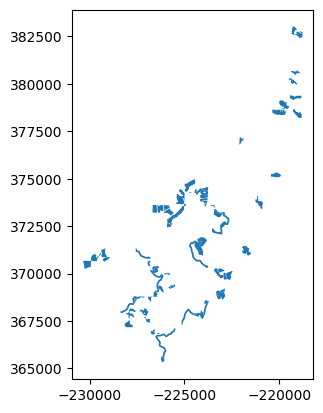

In [206]:
shapely_arr_polygon.plot()

In [220]:
listpoly = flatten([[a.intersection(b), a.difference(b), b.difference(a)] 
                        for a, b in itertools.combinations(shapely_arr_polygon, 2)])

In [222]:
listpoly_flat = flatten([pol if isinstance(pol, Polygon) else list(pol.geoms) for pol in listpoly])


In [224]:
list(listpoly_flat)

[<POLYGON ((-225029.518 373713.76, -225031.609 373712.706, -225032.31 373712....>,
 <POLYGON ((-225034.654 373711.171, -225040.756 373708.096, -225042.288 37370...>,
 <POLYGON ((-226150.694 365321.815, -226108.396 365360.463, -226085.084 36538...>,
 <POLYGON ((-225864.622 366697.352, -225866.22 366696.302, -225906.41 366671....>,
 <POLYGON ((-227147.204 368736.26, -227151.635 368735.045, -227156.167 368734...>,
 <POLYGON ((-226756.08 368775.03, -226756.309 368782.629, -226757.143 368810....>,
 <POLYGON ((-226639.662 368780.97, -226633.835 368797.021, -226632.407 368841...>,
 <POLYGON ((-226296.419 369897.298, -226295.381 369899.311, -226292.22 369904...>,
 <POLYGON ((-226787.875 370312.528, -226792.645 370257.178, -226793.084 37025...>,
 <POLYGON ((-226927.761 370476.023, -226929.785 370481.318, -226930.327 37048...>,
 <POLYGON ((-226952.568 370880.041, -226947.982 370883.807, -226942.945 37088...>,
 <POLYGON ((-225908.708 372710.695, -225908.696 372710.856, -225908.62 372710...>,
 <PO

In [186]:
remove_duplicates()

,geometry
0,"POLYGON ((-105173.821 71562.967, -105174.443 7..."
1,"POLYGON ((-105174.443 71563.308, -105173.821 7..."
2,"POLYGON ((-105174.443 71563.308, -105182.636 7..."
3,"POLYGON ((-105182.636 71567.815, -105174.443 7..."
4,"POLYGON ((-105182.636 71567.815, -105184.058 7..."
...,...
1069,"POLYGON ((-105181.75 71573.642, -105181.265 71..."
1070,"POLYGON ((-105249.948 71534.725, -105250.766 7..."
1071,"POLYGON ((-105249.728 71534.918, -105249.948 7..."
1072,"POLYGON ((-105207.484 71583.053, -105207.441 7..."


In [244]:
from shapely import Polygon, MultiPolygon
from shapely import LineString
from shapely.ops import unary_union, polygonize

def exterior_ring_reconstruction_NOP(shapely_arr_polygon):
    #pair wise intersect and difference polygons
    listpoly = flatten([[a.intersection(b), a.difference(b), b.difference(a)] 
                        for a, b in itertools.combinations(shapely_arr_polygon, 2)])
    # remove other geom type
    listpoly = [pol for pol in listpoly if (isinstance(pol, Polygon) | isinstance(pol, MultiPolygon))]
    # explode multi-polygon
    listpoly_flat = flatten([pol if isinstance(pol, Polygon) else list(pol.geoms) for pol in listpoly])

    # convert polygon to linestring rings
    rings = [LineString(list(pol.exterior.coords)) for pol in listpoly_flat]
    # union to get all polygons
    union = unary_union(rings)
    return [geom for geom in polygonize(union)]
    

In [252]:
i = 8751

<Axes: >

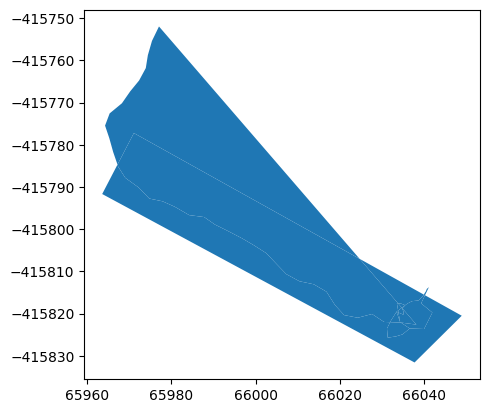

In [253]:
gpd.GeoDataFrame({'geometry': exterior_ring_reconstruction_NOP(pd.concat([gdf.iloc[[i]], interaction_gdf_list[i]]).geometry)}).plot()

In [228]:
gdf[gdf.TRMTID_USER.isin(nop_list)].index

Index([ 189,  474,  475,  951,  952,  955,  956,  963,  964,  966,
       ...
       8457, 8477, 8546, 8549, 8559, 8586, 8599, 8671, 8700, 8751],
      dtype='int64', length=177)

In [254]:
%%time
out = []
for i in tqdm(gdf[gdf.TRMTID_USER.isin(nop_list)].index):
    # skip those without any sindex intersection
    if len(interaction_gdf_list[i]) == 0:
        out.append(gdf.iloc[[i]])
        continue
    nop_cur = exterior_ring_reconstruction_NOP(pd.concat([gdf.iloc[[i]], interaction_gdf_list[i]]).geometry)
    # drop area close to 0 non overlapping polygons
    nop_cur = [pol for pol in nop_cur if not np.isclose(pol.area, 0)]

    out += nop_cur

100%|████████████████████████████████████████████████████████████████████████████████| 177/177 [03:48<00:00,  1.29s/it]

CPU times: total: 3min 47s
Wall time: 3min 48s


In [255]:
out_gdf = gpd.GeoDataFrame({'geometry': out})

In [239]:
import matplotlib.pyplot as plt

In [258]:
out_gdf.crs = dissolved_point.crs

In [259]:
nop_intersection = gpd.sjoin(dissolved_point[dissolved_point['TRMTID_USER'].isin(nop_list)], out_gdf, how='left', predicate='intersects').reset_index()

In [268]:
nop_intersection.sort_values('ACTIVITY_QUANTITY').drop_duplicates('index_right', keep='last').drop_duplicates('TRMTID_USER', keep='last')

,index,TRMTID_USER,geometry,ACTIVITY_QUANTITY,AGENCY,index_right
1177,8006,{CB47C41C-A32D-44F4-A13C-6DCA92E36ABD}-CNRA,POINT (-349779.262 435330.018),0.000002,CNRA,21528
1228,8559,{F32B2D43-FCFD-4981-9BEF-91D88D2F2B7A}-CNRA,POINT (203047.337 -490891.34),0.000020,CNRA,35567
1044,6629,{693DDFAE-3D7C-4E41-8316-B5F339F548E1}-CNRA,POINT (-79883.746 -303073.565),0.000028,CNRA,21311
1189,8050,{CE8A37A9-ED9C-4547-BA81-9ABB7AC10CA7}-CNRA,POINT (203223.504 -490960.065),0.000054,CNRA,34599
1007,6409,{5B072D55-F476-4F20-AD0B-27DB8856F547}-CNRA,POINT (203220.965 -490958.468),0.000171,CNRA,26048
...,...,...,...,...,...,...
969,5930,{39894F2E-C681-4EB0-8C51-83FD20E6E27B}-CNRA,POINT (312755.227 -540654.018),214.270000,CNRA,30715
887,4961,TI-454194,POINT (-127153.141 369593.329),222.898857,TIMBER,21182
1070,7015,{82E74083-CE76-4A75-B2F4-EF14CE9F4C1F}-CNRA,POINT (-50062.542 370444.57),250.000000,CNRA,29587
1223,8549,{F288A09D-C234-40AA-9A03-B0C565F73DD0}-CNRA,POINT (-90498.314 253683.228),258.000000,CNRA,29296


In [266]:
nop_intersection.groupby(['index_right', 'TRMTID_USER']).max(['ACTIVITY_QUANTITY'])

index  \
index_right TRMTID_USER                                          
0           050254F025414001088                            189   
15          0503566INV000053002                            474   
20          0503566INV000053003                            475   
28          0503566INV000053003                            475   
29          0503566INV000053002                            474   
...                                                        ...   
35824       {FF4B3BE2-5F65-4FDB-9B15-1294EE9CBA9B}-CNRA   8751   
35829       {BFD499B2-7E07-41CD-AAEE-2DE317DD208D}-CNRA   7837   
            {D1C3557D-A908-48E6-864A-7E82E9384208}-CNRA   8104   
35830       {1C802D08-9DCE-4C8C-B046-F6E4FDB07413}-CNRA   5515   
            {CCE06964-50E7-440B-83DF-F0475441F599}-CNRA   8028   

                                                         ACTIVITY_QUANTITY  
index_right TRMTID_USER                                                     
0           050254F025414001088                                 157.000000  
15          0503566INV000053002                                   0.100000  
20          0503566INV000053003                                   0.100000  
28          0503566INV000053003                                   0.100000  
29          0503566INV000053002                                   0.100000  
...                                                                    ...  
35824       {FF4B3BE2-5F65-4FDB-9B15-1294EE9CBA9B}-CNRA           0.000764  
35829       {BFD499B2-7E07-41CD-AAEE-2DE317DD208D}-CNRA           0.005012  
            {D1C3557D-A908-48E6-864A-7E82E9384208}-CNRA           0.004248  
35830       {1C802D08-9DCE-4C8C-B046-F6E4FDB07413}-CNRA           0.010865  
            {CCE06964-50E7-440B-83DF-F0475441F599}-CNRA           0.009857  

[1248 rows x 2 columns]

<Axes: >

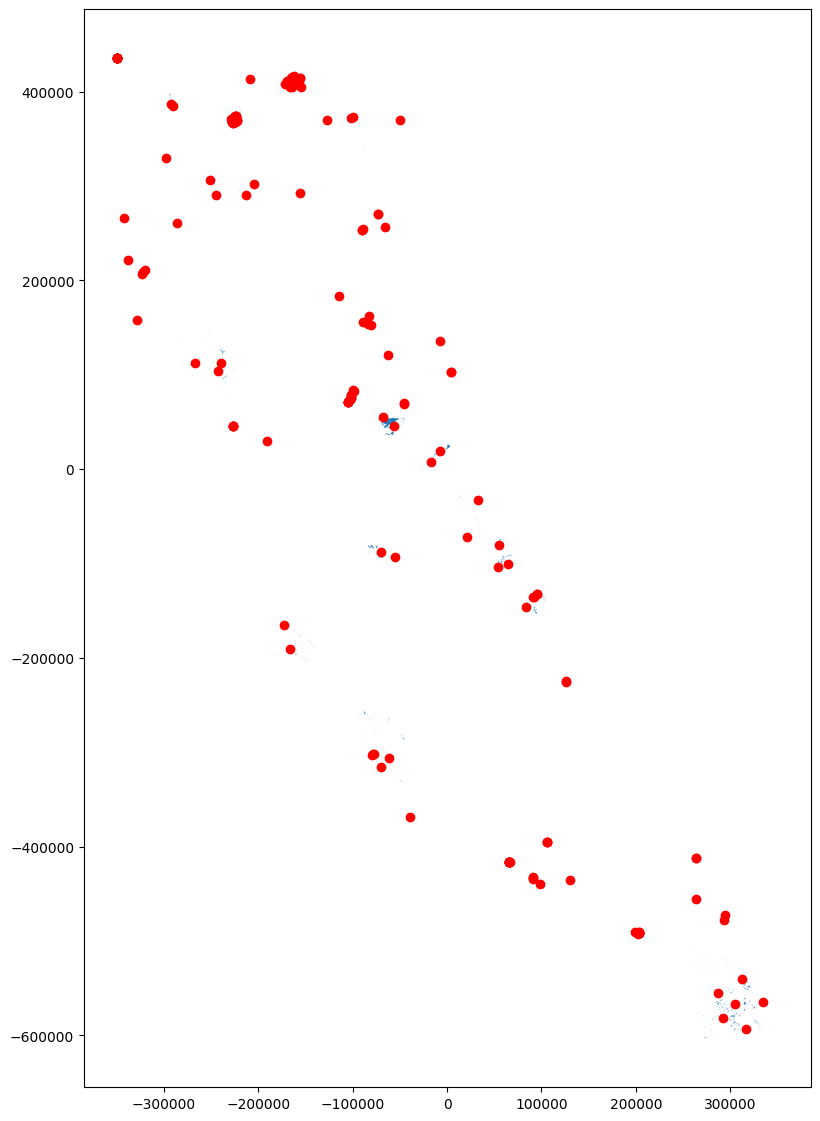

In [256]:
f, ax = plt.subplots()
f.set_size_inches(14, 14)
remove_duplicates(out_gdf).plot(ax=ax)
dissolved_point[dissolved_point.TRMTID_USER.isin(nop_list)].plot(ax=ax,c='red',)

In [ ]:
%%time
out = get_NOP(dissolved_cur_y)

 53%|█████████████████████████████████████▊                                 | 4742/8903 [1:37:47<237:25:51, 205.42s/it]

In [ ]:
4742

In [66]:
# author: James Falter @ARB
# Function to find local intersections between a target feature and a set of features
def get_interaction_list(gdf):
    # Build spatial index for efficient bounding box queries
    sindex = gdf.sindex

    # Store results in a pre-formatted list
    interaction_gdf_list = [None]*len(gdf)

    for idx, row in gdf.iterrows():
        # Get the bounding box of the current feature
        bounds = row.geometry.bounds

        # Find possible neighbors using bounding box intersection
        possible_neighbors = list(sindex.intersection(bounds))

        # Remove self from possible neighbors
        possible_neighbors = [i for i in possible_neighbors if i != idx]

        # Check for actual intersection with each possible neighbor
        intersecting_neighbors = [
            i for i in possible_neighbors
            if row.geometry.intersects(gdf.loc[i].geometry)
        ]

        # Assign results if not empty
        if len(intersecting_neighbors) > 0:
            interaction_gdf_list[idx] = gdf.iloc[intersecting_neighbors]
        else:
            interaction_gdf_list[idx] = []

    return interaction_gdf_list

In [19]:
# author: James Falter @ARB
# Function to recursively decompose a set of features into non-overlapping polygons (NOPs)
def recursive_nop_decomposition(features_gdf):

    # Loop through all features to find full sets of intersecting and non-intersecting features
    interaction_gdf_list = get_interaction_list(features_gdf)

    interaction_gdf_rows_list = [len(gdf) for gdf in interaction_gdf_list]
    non_intersecting_indices = [i for i, count in enumerate(interaction_gdf_rows_list) if count == 0]
    intersecting_indices  = [i for i, count in enumerate(interaction_gdf_rows_list) if count > 0]

    if len(non_intersecting_indices) > 0:
        non_intersecting_gdf = features_gdf.iloc[non_intersecting_indices].copy()

    # Test to see if any intersecting features were found
    if len(intersecting_indices) == 0:
        return features_gdf
    
    else:
        # Define intersecting features of interest and their set of intersecting neighbors
        intersecting_features_gdf = features_gdf.iloc[intersecting_indices].copy().reset_index(drop=True)
        intersecting_gdf_list = [interaction_gdf_list[i] for i in intersecting_indices]

        nop_gdf_list = []
        
        #Loop through the remaining sub-set of intersecting features
        for idx, row in intersecting_features_gdf.iterrows():
            lvl2_target_gdf = intersecting_features_gdf.loc[[idx]]
            lvl2_neighbors_gdf = intersecting_gdf_list[idx]
            
            # keep_geom_type=False will often time produce artifact in geometry of line/point
            # only keep polygon/multipolygon
            lvl2_neighbors_gdf = lvl2_neighbors_gdf[lvl2_neighbors_gdf.geom_type.isin(['MultiPolygon', 'Polygon'])]
            
            diff_nop_gdf = lvl2_target_gdf.overlay(
                lvl2_neighbors_gdf, 
                how='difference', 
                keep_geom_type=False)
            
            inter_nop_gdf = lvl2_target_gdf.overlay(
                lvl2_neighbors_gdf, 
                how='intersection', 
                keep_geom_type=False)

            # Recursively decompose any intersecting intersections
            lvl2_inter_nop_gdf = recursive_nop_decomposition(inter_nop_gdf)

            # Compile all NOPs for a given target feature in the NOP list
            nop_gdf_list.append(pd.concat([diff_nop_gdf, lvl2_inter_nop_gdf], ignore_index=True))

        # Concatenate all independent NOPs found plus set of non-intersecting features
        nop_gdf = pd.concat(nop_gdf_list, ignore_index=True)

        if len(non_intersecting_indices) > 0:
            nop2_gdf = pd.concat([non_intersecting_gdf, nop_gdf], ignore_index=True)
        else:
            nop2_gdf = nop_gdf

        # Get rid of duplicate geometries created by bidirectional pairwise intersections
        unique_nop_gdf = remove_duplicates(nop2_gdf)

        return unique_nop_gdf

In [67]:
def flatten(container):
    for i in container:
        if isinstance(i, (list,tuple)):
            for j in flatten(i):
                yield j
        else:
            yield i

In [94]:
def get_NOP_recur(gdf1, gdf2):
    gdf1 = gdf1[gdf1.geom_type.isin(['MultiPolygon', 'Polygon'])]
    gdf2 = gdf2[gdf2.geom_type.isin(['MultiPolygon', 'Polygon'])]

    # keep_geom_type=False will often time produce artifact in geometry of line/point
    # only keep polygon/multipolygon
    intersection = gpd.overlay(gdf1, gdf2, how='intersection', keep_geom_type=False)
    intersection = intersection[intersection.geom_type.isin(['MultiPolygon', 'Polygon'])]

    difference = gpd.overlay(gdf1, gdf2, how='difference', keep_geom_type=False)
    difference = difference[difference.geom_type.isin(['MultiPolygon', 'Polygon'])]

    temp_nop = pd.concat([intersection, difference])
    temp_nop = remove_duplicates(temp_nop)
    if len(temp_nop) <= 1:
        return [gdf1]
    else:
        return [get_NOP_recur(temp_nop.iloc[[i]], 
                              pd.concat([temp_nop.iloc[0:i],temp_nop.iloc[i+1:]])) for i in range(len(temp_nop))]

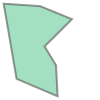

In [272]:
gdf.iloc[i].geometry

In [95]:
from tqdm import tqdm


def get_NOP(gdf):
    out = []
    interaction_gdf_list = get_interaction_list(gdf)
    for i in tqdm(range(len(gdf))):
        # skip those without any sindex intersection
        if len(interaction_gdf_list[i]) == 0:
            out.append(gdf.iloc[[i]])
            continue
        nop_cur = get_NOP_recur(gdf.iloc[[i]], interaction_gdf_list[i])
        nop_cur = pd.concat(flatten(nop_cur)).drop_duplicates('geometry')
        nop_cur = nop_cur[~np.isclose(nop_cur.area, 0)]
        
        out.append(nop_cur)
        
    return pd.concat(flatten(out)).drop_duplicates('geometry')

In [13]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
import dask_geopandas
# some data need to be converted to multi-type again
from utils.save_gdf_to_gdb import save_gdf_to_gdb

In [ ]:
%%time
from multiprocessing import Pool
interaction_gdf_list = get_interaction_list(dissolved_cur_y)
def get_NOP_mp(i):
    if len(interaction_gdf_list[i]) == 0:
        return(gdf.iloc[[i]])
    nop_cur = get_NOP_recur(gdf.iloc[[i]], interaction_gdf_list[i])
    nop_cur = pd.concat(flatten(nop_cur)).drop_duplicates('geometry')
    nop_cur = nop_cur[~np.isclose(nop_cur.area, 0)]

    return nop_cur


if __name__ == '__main__':
    pool = Pool(processes=8)
    
    pool.map(process_nop, range(len(dissolved_cur_y)))

In [213]:
%%time
out = get_NOP(dissolved_cur_y)

KeyboardInterrupt: 

In [75]:
from matplotlib import pyplot as plt

<Axes: >

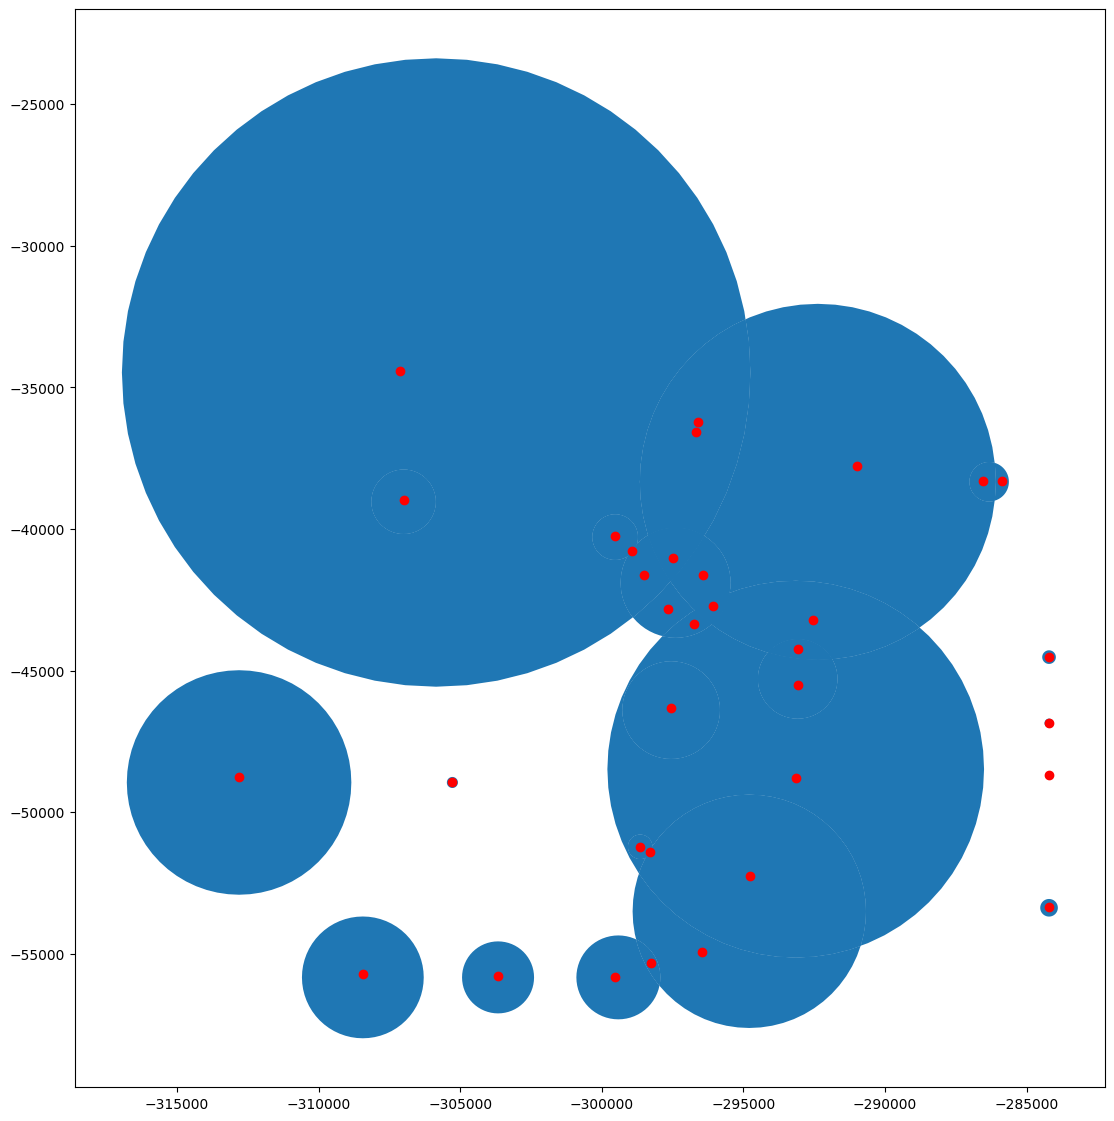

In [212]:
f, ax = plt.subplots()
f.set_size_inches(14, 14)
out.plot(ax=ax)
out.representative_point().drop_duplicates().plot(ax=ax,c='red',)

In [195]:
len(pd.concat(flatten(out)).representative_point().drop_duplicates())

34

In [ ]:
# line buffer simplification does not have enough spatial resolution for this sensitive probability calculation

In [243]:
buffered_poly[buffered_poly.TRMTID_USER == '{87AB0448-8E28-488F-A19A-3BF7C86336AA}-CNRA']

,PROJECTID_USER,AGENCY,ORG_ADMIN_p,PROJECT_CONTACT,PROJECT_EMAIL,ADMINISTERING_ORG,PROJECT_NAME,PROJECT_STATUS,PROJECT_START,PROJECT_END,...,SHAPE_Area,index_right,FIPS,STATE,ST_ABBREV,SQMI,POPULATION,Shape_Length_1,Shape_Area_1,geometry
12653,{312AFFED-EF63-47C9-82C8-363FD8AAA6FF}-CNRA,CNRA,CALFIRE,CAL FIRE Data Contact,FRAPdatacontact@fire.ca.gov,CALFIRE,High Sierra Front Country Fuel Breaks Project,COMPLETE,2022-03-01 00:00:00+00:00,2023-12-05 00:00:00+00:00,...,NaN,0.0,06,California,CA,158144.83,39648525,5.682717e+06,4.095942e+11,"MULTIPOLYGON (((63419.474 -101968.354, 63428.3..."
12655,{312AFFED-EF63-47C9-82C8-363FD8AAA6FF}-CNRA,CNRA,CALFIRE,CAL FIRE Data Contact,FRAPdatacontact@fire.ca.gov,CALFIRE,High Sierra Front Country Fuel Breaks Project,COMPLETE,2022-03-01 00:00:00+00:00,2023-12-05 00:00:00+00:00,...,NaN,0.0,06,California,CA,158144.83,39648525,5.682717e+06,4.095942e+11,"MULTIPOLYGON (((63419.474 -101968.354, 63428.3..."


In [244]:
max(buffered_ln.ACTIVITY_QUANTITY*4046.86/buffered_ln.geometry.area)

1.461965217156889

In [245]:
min(buffered_ln.ACTIVITY_QUANTITY*4046.86/buffered_ln.geometry.area)

0.9970375098538626

In [217]:
dissolved_cur_y = dissolved_cur_y.reset_index()

In [219]:
%%time
dissolved_cur_y['geom'] = dissolved_cur_y.geometry

gdf = gpd.sjoin(dissolved_cur_y, dissolved_cur_y,
                how="inner",
                predicate="intersects",
                lsuffix="left",
                rsuffix="right")

gdf = gdf[gdf.index != gdf.index_right]
gdf['intersection_geom'] = gdf['geom_left'].intersection(gdf['geom_right'])
gdf['intersection'] = gdf.apply(
    lambda r: f"{r['TRMTID_USER_left']} & {r['TRMTID_USER_right']}", axis=1)

CPU times: total: 11.6 s
Wall time: 11.6 s


In [220]:
gdf.set_geometry('intersection_geom', drop=True, inplace=True)

C:\Users\sky\AppData\Local\Temp\ipykernel_1265932\184717377.py:1: FutureWarning: The `drop` keyword argument is deprecated and in future the only supported behaviour will match drop=False. To silence this warning and adopt the future behaviour, stop providing `drop` as a keyword to `set_geometry`. To replicate the `drop=True` behaviour you should update your code to
`geo_col_name = gdf.active_geometry_name; gdf.set_geometry(new_geo_col).drop(columns=geo_col_name).rename_geometry(geo_col_name)`.
  gdf.set_geometry('intersection_geom', drop=True, inplace=True)


In [299]:
interestion_gdf = gdf[['ACTIVITY_QUANTITY_left', 'ACTIVITY_QUANTITY_right', 'TRMTID_USER_left', 'geometry']]

In [327]:
gdf['prob_left'] = gdf.ACTIVITY_QUANTITY_left*4046.86/gdf.geom_left.area
gdf.loc[gdf['prob_left'] > 1, 'prob_left'] = 1
gdf['prob_right'] = gdf.ACTIVITY_QUANTITY_right*4046.86/gdf.geom_right.area
gdf.loc[gdf['prob_right'] > 1, 'prob_right'] = 1

In [300]:
# tolerence for geometry smoothing on intersection results to keep result geom type be multipolygon/polygon
tolerence = 1e-8

In [301]:
diff_buffer = interestion_gdf.buffer(tolerence)

In [302]:
diff_buffer_gdf = interestion_gdf.copy()
diff_buffer_gdf.geometry = diff_buffer

In [285]:
%%time
diff_gdf = dissolved_cur_y.overlay(diff_buffer_gdf, how='difference', keep_geom_type=False)
#diff_gdf.geometry = diff_gdf.buffer(tolerence)

CPU times: total: 2min 32s
Wall time: 2min 32s


In [286]:
sum(diff_gdf.geometry.area)

3032954594.3421783

In [271]:
sum(dissolved_cur_y.geometry.area)

3954377595.371912

In [163]:
sum(diff_gdf.geometry.area) + sum(interestion_gdf.geometry.area)

4015915939.452771

In [162]:
sum(interestion_gdf.geometry.area)

982945942.8896587

In [155]:
interesection_all = interestion_gdf.dissolve()

401641724.05769753

In [165]:
sum(diff_gdf.geometry.area) + sum(interesection_all.area)

3434611720.6208105

In [287]:
diff_gdf['prob_self'] = diff_gdf.geometry.area/diff_gdf.geom.area

In [288]:
diff_gdf.loc[diff_gdf['prob_self']>1, 'prob_self'] = 1

In [291]:
diff_gdf

,TRMTID_USER,geometry,ACTIVITY_QUANTITY,geom,prob_self
0,01-DN-101-DN-NOR-WUI,"MULTIPOLYGON (((-342291.412 406063.922, -34229...",32.40,"MULTIPOLYGON (((-342583.596 406960.852, -34258...",0.809056
1,01-DN-169-DN-NOR-WUI,"MULTIPOLYGON (((-336986.135 396726.867, -33698...",8.50,"POLYGON ((-337005.425 396726.106, -336987.306 ...",0.999887
2,01-DN-197-DN-NOR-WUI,"POLYGON ((-339575.871 428285.734, -339559.487 ...",5.86,"POLYGON ((-339603.722 428203.383, -339600.298 ...",0.999945
3,01-DN-199-DN-NOR-NON,"MULTIPOLYGON (((-345198.562 428197.653, -34519...",10.00,"POLYGON ((-345202.203 428196.454, -345202.18 4...",0.999964
4,01-HUM-036-HUM-NOR-WUI,"MULTIPOLYGON (((-351052.646 289067.603, -35105...",45.00,"POLYGON ((-351049.545 289066.052, -351065.559 ...",0.999969
...,...,...,...,...,...
6000,{FF598D57-7CFF-4FB8-800C-30CC05762B0F}-CNRA,"POLYGON ((113262.243 -408589.435, 113257.71 -4...",20.00,"POLYGON ((113262.243 -408589.435, 113257.71 -4...",1.000000
6001,{FFBBE1BD-76E2-4C81-A648-836A7A5BE12B}-CNRA,"MULTIPOLYGON (((136377.394 -255147.671, 136376...",1.00,"MULTIPOLYGON (((136377.394 -255147.671, 136376...",1.000000
6002,{FFCAC627-1969-4812-99E7-CF25F1D98D4A}-CNRA,"MULTIPOLYGON (((-62945.288 105650.715, -62944....",10.00,"POLYGON ((-62943.677 105739.715, -62944.36 105...",0.031704
6003,{FFCE3441-F814-4C8C-B2A5-4273E9B64873}-CNRA,"POLYGON ((83235.69 -138825.181, 83253.236 -138...",37.00,"POLYGON ((83235.69 -138825.181, 83253.236 -138...",1.000000


In [280]:
intersection_gdf

,TRMTID_USER_1,ACTIVITY_QUANTITY_1,TRMTID_USER_2,ACTIVITY_QUANTITY_2,geometry
1,01-DN-101-DN-NOR-WUI,32.4,01-DN-169-DN-NOR-WUI,8.50,"POLYGON ((-337035.564 396722.601, -337034.107 ..."
2,01-DN-101-DN-NOR-WUI,32.4,01-DN-197-DN-NOR-WUI,5.86,"POLYGON ((-343862.16 436805.722, -343862.805 4..."
3,01-DN-101-DN-NOR-WUI,32.4,01-DN-199-DN-NOR-NON,10.00,"POLYGON ((-345196.93 428198.472, -345197.501 4..."
4,01-DN-101-DN-NOR-WUI,32.4,01-HUM-101-HUM-NOR-NON,88.22,"MULTIPOLYGON (((-337573.844 390254.38, -337573..."
5,01-DN-101-DN-NOR-WUI,32.4,{7A8F6B6C-4B62-419C-96B2-322264EBCD8D}-CNRA,225.00,"MULTIPOLYGON (((-342584.01 406966.193, -342591..."
...,...,...,...,...,...
19155,{FE96B4DC-B6EA-4011-A06B-DF502E15B1A0}-CNRA,3.8,{EF7C0DBE-3D73-47A0-948E-4BFC24D0CE94}-CNRA,6.30,"POLYGON ((324754.869 -538602.318, 324758.391 -..."
19156,{FE96B4DC-B6EA-4011-A06B-DF502E15B1A0}-CNRA,3.8,{F8234F64-8357-4AA0-A906-D9772D8A99A8}-CNRA,8.60,"POLYGON ((324748.788 -538617.841, 324748.431 -..."
19157,{FE96B4DC-B6EA-4011-A06B-DF502E15B1A0}-CNRA,3.8,{FC1D44EC-E5E8-4BB9-8197-A8C57D6B9688}-CNRA,1.00,"POLYGON ((324756.902 -538599.787, 324761.72 -5..."
19160,{FED24A6D-4C52-41C9-A42E-F9C8FE0A0E43}-CNRA,21.0,{1CECCD06-ABEE-4FBF-B7B0-A5A240E75A19}-CNRA,21.00,"MULTIPOLYGON (((-205565.255 331583.555, -20557..."


In [293]:
dissolved_cur_y['p_ACTIVITY'] = dissolved_cur_y.ACTIVITY_QUANTITY*4046.86/dissolved_cur_y.geometry.area

In [294]:
# enforce p <= 1 on inaccurate buffered polygons (mostly from line data)
dissolved_cur_y.loc[dissolved_cur_y['p_ACTIVITY'] > 1, 'p_ACTIVITY'] = 1

In [ ]:
dissolved_cur_y['FOOTPRINT_ACRES'] = dissolved_cur_y.apply()

In [304]:
test_id = "01-DN-101-DN-NOR-WUI"

In [329]:
intersecting_areas = gdf[gdf['TRMTID_USER_left'] == test_id]

In [321]:
intersecting_areas['TRMTID_USER_right']

,TRMTID_USER_left,geometry,ACTIVITY_QUANTITY_left,geom_left,index_right,TRMTID_USER_right,ACTIVITY_QUANTITY_right,geom_right,intersection,prob_left
0,01-DN-101-DN-NOR-WUI,"MULTIPOLYGON (((-337574.449 390254.641, -33757...",32.4,"MULTIPOLYGON (((-342583.596 406960.852, -34258...",6,01-HUM-101-HUM-NOR-NON,88.22,"MULTIPOLYGON (((-322811.141 227232.756, -32281...",01-DN-101-DN-NOR-WUI & 01-HUM-101-HUM-NOR-NON,4.375942e-08
0,01-DN-101-DN-NOR-WUI,"POLYGON ((-337035.564 396722.601, -337034.107 ...",32.4,"MULTIPOLYGON (((-342583.596 406960.852, -34258...",1,01-DN-169-DN-NOR-WUI,8.50,"POLYGON ((-337005.425 396726.106, -336987.306 ...",01-DN-101-DN-NOR-WUI & 01-DN-169-DN-NOR-WUI,2.956419e-05
0,01-DN-101-DN-NOR-WUI,"MULTIPOLYGON (((-342584.01 406966.193, -342591...",32.4,"MULTIPOLYGON (((-342583.596 406960.852, -34258...",5311,{7A8F6B6C-4B62-419C-96B2-322264EBCD8D}-CNRA,225.00,"MULTIPOLYGON (((-338572.881 372842.016, -33855...",01-DN-101-DN-NOR-WUI & {7A8F6B6C-4B62-419C-96B...,1.909002e-01
0,01-DN-101-DN-NOR-WUI,"POLYGON ((-343862.16 436805.722, -343862.805 4...",32.4,"MULTIPOLYGON (((-342583.596 406960.852, -34258...",2,01-DN-197-DN-NOR-WUI,5.86,"POLYGON ((-339603.722 428203.383, -339600.298 ...",01-DN-101-DN-NOR-WUI & 01-DN-197-DN-NOR-WUI,6.615047e-06
0,01-DN-101-DN-NOR-WUI,"POLYGON ((-345196.93 428198.472, -345197.501 4...",32.4,"MULTIPOLYGON (((-342583.596 406960.852, -34258...",3,01-DN-199-DN-NOR-NON,10.00,"POLYGON ((-345202.203 428196.454, -345202.18 4...",01-DN-101-DN-NOR-WUI & 01-DN-199-DN-NOR-NON,7.812525e-06


In [315]:
p_activity = dissolved_cur_y[dissolved_cur_y['TRMTID_USER'].isin(intersecting_areas['TRMTID_USER_right'])].p_ACTIVITY

In [320]:
p_treatment = 1 - sum(1-p_activity)

In [ ]:
def get_footprint_acre(row):
    intersecting_areas = gdf[gdf['TRMTID_USER_left'] == row['TRMTID_USER']]
    p_activity = dissolved_cur_y[dissolved_cur_y['TRMTID_USER'] in intersecting_areas['TRMTID_USER_right']].p_ACTIVITY
    
    p_treatment = 1 - sum(1-p_activity)

<Axes: >

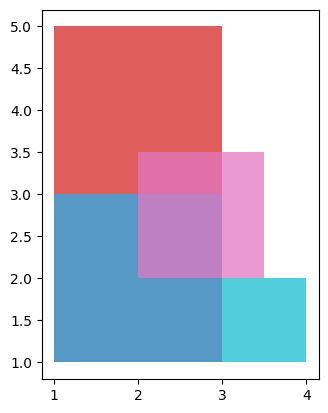

In [332]:
polygons = [
    Polygon([[1, 1], [1, 3], [3, 3], [3, 1], [1, 1]]),
    Polygon([[1, 3], [1, 5], [3, 5], [3, 3], [1, 3]]),
    Polygon([[2, 2], [2, 3.5], [3.5, 3.5], [3.5, 2], [2, 2]]),
    Polygon([[3, 1], [3, 2], [4, 2], [4, 1], [3, 1]]),
]
gdf = gpd.GeoDataFrame(data={'A': list('ABCD')}, geometry=polygons)
gdf.plot(column='A', alpha=0.75)

In [333]:
non_overlapping = []
for n, p in enumerate(polygons[:-1], 1):
    if not any(p.overlaps(g) for g in polygons[n:]):
        non_overlapping.append(p)

In [334]:
non_overlapping

[<POLYGON ((2 2, 2 3.5, 3.5 3.5, 3.5 2, 2 2))>]

In [338]:
region_id = '04'
usfs_input_gdb_path = r'D:\WORK\wildfire\Interagency-Tracking-System\V2.0\FACTS_V2.0\Actv_CommonAttribute_PL_Region{}.gdb'.format(region_id)
        

In [339]:
gpd.list_layers(usfs_input_gdb_path)

,name,geometry_type
0,Actv_CommonAttribute_PL,MultiPolygon


In [3]:
gpd.list_layers(report_path)

,name,geometry_type
0,footprint2021,MultiPolygon Z
1,footprint2022,MultiPolygon Z
2,footprint2023,MultiPolygon Z
3,footprint2024,MultiPolygon
